# Explore Fortune 100 & BLM Dataset

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import matplotlib.units as munits
import matplotlib.dates as mdates
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from datetime import date

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

savefig_options = {
    'dpi': 1200, 
    'bbox_inches': 'tight'
}

%matplotlib inline

In [2]:
DATA_DIR = 'fortune-100-blm-dataset/data/'
IMG_DIR = 'site/img/'

In [3]:
df_c = pd.read_csv(os.path.join(DATA_DIR, 'fortune-100.csv')).dropna()
df_t = pd.read_csv(os.path.join(DATA_DIR, 'fortune-100-tweets.csv'), parse_dates=['Datetime'])
df_b = df_t[df_t['Racial Justice']].copy()

## The quiet corporations

In [4]:
quiet_corps = [corp for corp in df_c['Corporation'] if corp not in df_b['Corporation'].unique()]
len(quiet_corps), quiet_corps

(19,
 ['Exxon Mobil',
  'Ford Motor',
  'Phillips 66',
  'Valero Energy',
  'General Electric',
  'Raytheon Technologies',
  'Boeing',
  'Centene',
  'Lockheed Martin',
  'Energy Transfer',
  'Charter Communications',
  'New York Life Insurance',
  'Best Buy',
  'Oracle',
  'General Dynamics',
  'Progressive',
  'Publix Super Markets',
  'Northrop Grumman',
  'StoneX'])

## Interest over time

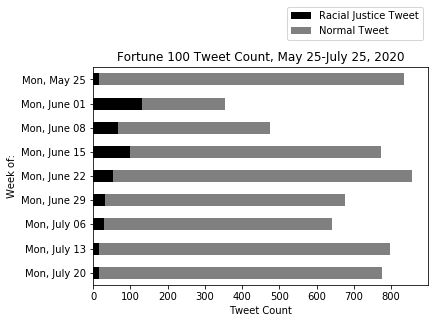

In [5]:
start_date = pd.Timestamp('2020-05-25')
end_date = pd.Timestamp('2020-07-30')

d = {}
yticklabel_map = {}
for i, (dt, df) in enumerate(
        df_t.groupby(pd.Grouper(key='Datetime', freq='W-SUN', closed='right'))
    ):
    if start_date <= dt <= end_date:
        d[i] = {
            'Racial Justice Tweet': df[df['Racial Justice']]['ID'].count(),
            'Normal Tweet': df[~df['Racial Justice']]['ID'].count()
        }
        yticklabel_map[i] = (dt - pd.Timedelta('6 days')).strftime('Mon, %B %d')
    
df_o = pd.DataFrame(d).T
ax = df_o.sort_index(ascending=False).plot(
    kind='barh', stacked=True, color=['k', 'grey'], title='Fortune 100 Tweet Count, May 25-July 25, 2020'
)
ax.set_yticklabels([yticklabel_map[int(tick.get_text())] for tick in ax.get_yticklabels()])
ax.set_ylabel('Week of:')
ax.set_xlabel('Tweet Count')
ax.legend(bbox_to_anchor=(1, 1.3))

plt.savefig(os.path.join(IMG_DIR, 'tweet-count-by-week.png'), **savefig_options)

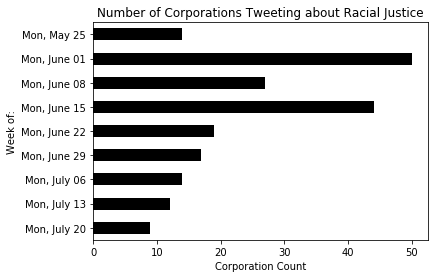

In [6]:
start_date = pd.Timestamp('2020-05-25')
end_date = pd.Timestamp('2020-07-30')

d = {}
dcorps = {}
yticklabel_map = {}
for i, (dt, df) in enumerate(
        df_t.groupby(pd.Grouper(key='Datetime', freq='W-SUN', closed='right'))
    ):
    if start_date <= dt <= end_date:
        df_rj = df[df['Racial Justice']]
        dcorps[i] = df_rj['Corporation'].unique()
        d[i] = df_rj['Corporation'].unique().shape[0]
        yticklabel_map[i] = (dt - pd.Timedelta('6 days')).strftime('Mon, %B %d')
    
df_o = pd.DataFrame(d, index=['']).T
ax = df_o.sort_index(ascending=False).plot(
    kind='barh', color=['k', 'grey'], 
    title='Number of Corporations Tweeting about Racial Justice'
)
ax.set_yticklabels([yticklabel_map[int(tick.get_text())] for tick in ax.get_yticklabels()])
ax.set_ylabel('Week of:')
ax.set_xlabel('Corporation Count')
ax.get_legend().remove()

plt.savefig(os.path.join(IMG_DIR, 'rj-corp-count-by-week.png'), **savefig_options)

## Response immediacy

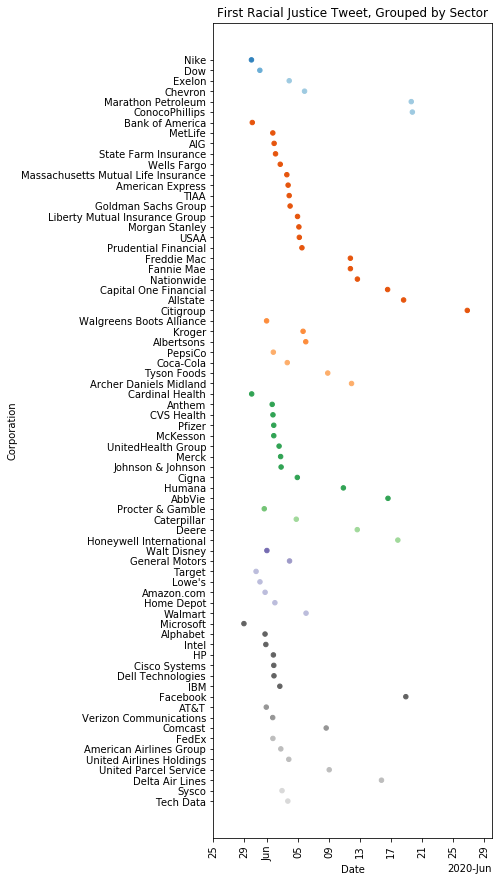

In [7]:
m = df_b.groupby('Corporation')['Datetime'].min().sort_values(ascending=False)
df = pd.DataFrame(m)
df['Corporation'] = df.index
df['Sector'] = df['Corporation'].apply(lambda x: df_c[df_c['Corporation'] == x].iloc[0]['Sector'])

df = df.sort_values(by=['Sector', 'Datetime'], ascending=False)

cmap = plt.get_cmap('tab20c', df['Sector'].unique().shape[0])
color_list = [rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
colormap = np.array(color_list)

ax = df.plot.scatter(
        x='Datetime', y='Corporation', title='First Racial Justice Tweet, Grouped by Sector', figsize=(5, 15), rot=90, 
        xlim=(date(2020, 5, 25), date(2020, 6, 30)), color=colormap[pd.Categorical(df['Sector']).codes])

ax.set_xlabel('Date')

plt.savefig(os.path.join(IMG_DIR, 'first-rj-tweet.png'), **savefig_options)

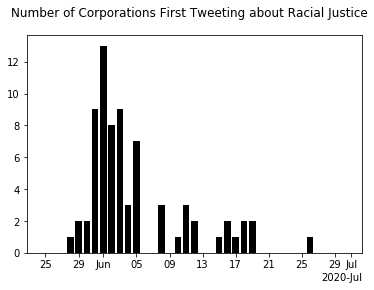

In [8]:
df['Date'] = df['Datetime'].dt.date
date_counts = df.groupby('Date')['Sector'].count()
x_axis_dates = pd.date_range( date(2020, 5, 25), date(2020, 7, 1)-datetime.timedelta(days=1), freq='d')
y = []
for x_axis_date in x_axis_dates:
    y.append(date_counts.get(date(x_axis_date.year, x_axis_date.month, x_axis_date.day), 0))
plt.bar(x=x_axis_dates, height=y, color='k')
plt.suptitle('Number of Corporations First Tweeting about Racial Justice')
plt.savefig(os.path.join(IMG_DIR, 'first-rj-tweet-hist.png'), **savefig_options)

## The "Black Lives Matter" Taboo

In [9]:
print((f"{df_b[df_b['BLM']]['Corporation'].unique().shape[0]} Fortune 100 corporations "
       "used the phrase 'Black Lives Matter' between May 25 and July 25."))
print((f"{df_b[df_b['Money']]['Corporation'].unique().shape[0]} corporations tweeted about money donated to racial justice initiatives"))

22 Fortune 100 corporations used the phrase 'Black Lives Matter' between May 25 and July 25.
49 corporations tweeted about money donated to racial justice initiatives


## Reacting to the Attack on the Capitol

In [10]:
df_i = pd.read_csv('supplementary-data/capitol-attack-tweets.csv')
print(f"{df_i['Handle'].unique().shape[0]} corporations responded to the insurrection.")

21 corporations responded to the insurrection.
